In [1]:
#!conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

In [2]:
import torch
import torchvision
import os
import pandas as pd
from skimage import io
from fastprogress import master_bar, progress_bar
import numpy as np 
from sklearn.metrics import roc_auc_score
from albumentations import Compose, Flip, ToGray

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

('1.6.0', 'cuda')

In [3]:
PATH = 'data'

os.listdir(PATH)

['jpeg224',
 'sample_submission.csv',
 'subset.csv',
 'subset_clean.csv',
 'test.csv',
 'test_clean.csv',
 'train.csv',
 'train_clean.csv',
 'train_clean_split.csv',
 'train_split.csv',
 'val_clean_split.csv',
 'val_split.csv']

In [4]:
train = pd.read_csv(f'{PATH}/train_clean.csv')

train.shape

(33126, 8)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   image_name                     33126 non-null  object
 1   patient_id                     33126 non-null  object
 2   sex                            33126 non-null  object
 3   age_approx                     33126 non-null  object
 4   anatom_site_general_challenge  33126 non-null  object
 5   diagnosis                      33126 non-null  object
 6   benign_malignant               33126 non-null  object
 7   target                         33126 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 2.0+ MB


In [6]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [8]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder()
cols = ["sex", "age_approx", "anatom_site_general_challenge"]
oh_encoder.fit(train[cols])
oh_encoder.categories_

[array(['female', 'male', 'unk'], dtype=object),
 array(['0.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0',
        '45.0', '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0',
        '85.0', '90.0', 'unk'], dtype=object),
 array(['head/neck', 'lower extremity', 'oral/genital', 'palms/soles',
        'torso', 'unk', 'upper extremity'], dtype=object)]

In [12]:
oh_encoder.transform([['female', '10.0', 'torso']]).toarray()

array([[1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [13]:
#train = pd.read_csv(f'{PATH}/train_clean_split.csv')
train = pd.read_csv(f'{PATH}/subset_clean.csv')
val = pd.read_csv(f'{PATH}/val_clean_split.csv')

train.shape, val.shape

((2220, 8), (10932, 8))

In [14]:
train['path'] = [f'{PATH}/jpeg224/train/{img}.jpg' for img in train['image_name']]
val['path'] = [f'{PATH}/jpeg224/train/{img}.jpg' for img in val['image_name']]

In [15]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,path
0,ISIC_0533349,IP_5208504,female,45.0,lower extremity,unknown,benign,0,data/jpeg224/train/ISIC_0533349.jpg
1,ISIC_8814612,IP_0414408,male,50.0,torso,unknown,benign,0,data/jpeg224/train/ISIC_8814612.jpg
2,ISIC_6515241,IP_6245507,male,45.0,lower extremity,unknown,benign,0,data/jpeg224/train/ISIC_6515241.jpg
3,ISIC_5075261,IP_2117218,male,40.0,upper extremity,unknown,benign,0,data/jpeg224/train/ISIC_5075261.jpg
4,ISIC_2624460,IP_1969685,male,50.0,torso,unknown,benign,0,data/jpeg224/train/ISIC_2624460.jpg


In [18]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, meta, labels=None, train=True, cache=False, trans=None):
        self.cache = cache
        self.images = [self.load_img(img) for img in images] if cache else images
        meta = oh_encoder.transform(meta).toarray()
        self.meta = torch.tensor(meta).float()
        self.train = train
        self.trans = trans
        if train:
            self.labels = [torch.tensor([lab]).float() for lab in labels] 
    
    def __len__(self):
        return len(self.images)
    
    def load_img(self, img):
        return io.imread(img)
    
    def __getitem__(self, ix):
        img = self.images[ix] if self.cache else self.load_img(self.images[ix])
        if self.trans:
            img = self.trans(image=img)['image']
        if self.train:
            return torch.from_numpy(img), self.meta[ix], self.labels[ix]
        return torch.from_numpy(img), self.meta[ix]
    
trans = Compose([
    Flip(),
    #ToGray(),
    # ...
])

In [20]:
dataset = {
    'train': Dataset(train['path'], train[cols], train['target'], cache=True, trans=trans),
    'val': Dataset(val['path'], val[cols], val['target'], cache=True, trans=trans)
}

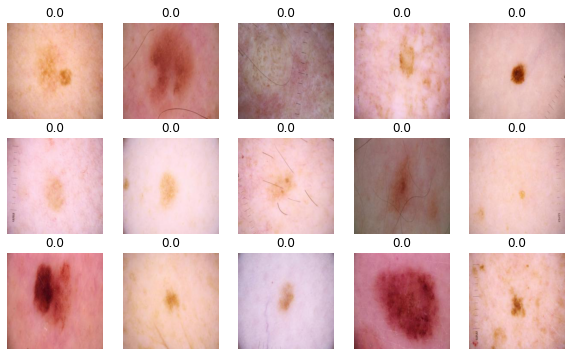

In [23]:
import matplotlib.pyplot as plt
import random

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        img, meta, label = dataset['train'][ix]
        plt.imshow(img)
        plt.title(label.item())
        plt.axis(False)
plt.show()

In [28]:
meta

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [31]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs=29):
        super().__init__()
        
        # image encoder
        resnet = torchvision.models.resnet50(pretrained=True)
        # freeze
        for param in resnet.parameters():
            param.requires_grad = False
        self.encoder = torch.nn.Sequential(*list(resnet.children())[:-1])
        
        # metadata encoder
        self.meta_encoder = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, 100),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(100, 3),
            torch.nn.ReLU(inplace=True)
        )
        
        # head
        self.head = torch.nn.Linear(2048+3, 1)
        
    def forward(self, x, y):
        B, H, W, C = x.shape
        x = (x / 255.).float().view(B, C, H, W)
        x = self.encoder(x)
        x = x.view(B, -1)
        y = self.meta_encoder(y)
        z = torch.cat([x, y], 1)
        z = self.head(z)
        return z

In [32]:
model = Net()

output = model(torch.randn(64, 224, 224, 3), torch.randn(64, 29))
output.shape

torch.Size([64, 1])

In [33]:
BATCH_SIZE = 64

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BATCH_SIZE)
}

In [34]:
imgs, meta, labels = next(iter(dataloader['train']))

imgs.shape, meta.shape, labels.shape

(torch.Size([64, 224, 224, 3]), torch.Size([64, 29]), torch.Size([64, 1]))

In [35]:
def AUC(outputs, labels):
    outputs = torch.sigmoid(outputs)
    outputs = outputs.numpy()
    labels = labels.numpy()
    auc = roc_auc_score(labels, outputs)
    return auc

In [36]:
net = Net()
net.to(DEVICE)

optimizer = torch.optim.Adam(net.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

EPOCHS = 10
validation_steps = 10
mb = master_bar(range(1, EPOCHS+1))
best_auc = 0
for epoch in mb:
    train_loss = []
    net.train()
    for batch in progress_bar(dataloader['train'], parent=mb):
        imgs, meta, labels = batch
        imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
        outputs = net(imgs, meta)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        mb.child.comment = f'loss {np.mean(train_loss):.5f}'
    val_loss = []
    net.eval()
    validation_step = 0
    val_outputs = torch.tensor([])
    val_targets = torch.tensor([])
    with torch.no_grad():
        for batch in progress_bar(dataloader['val'], parent=mb):
            imgs, meta, labels = batch
            imgs, meta, labels = imgs.to(DEVICE), meta.to(DEVICE), labels.to(DEVICE)
            outputs = net(imgs, meta)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            mb.child.comment = f'val_loss {np.mean(val_loss):.5f}'
            val_outputs = torch.cat([val_outputs, outputs.cpu()])
            val_targets = torch.cat([val_targets, labels.cpu()])
            validation_step += 1
            if validation_step > validation_steps:
                break
    auc = AUC(val_outputs, val_targets)
    if auc > best_auc:
        best_auc = auc
        torch.save(net, 'model.pth')
        print(f"Best model ! {auc:.5f}")
    mb.write(f'Epoch {epoch}/{EPOCHS} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} val_auc {auc:.5f}')

Best model ! 0.75138
Best model ! 0.78142
Best model ! 0.83957
Best model ! 0.84823
Best model ! 0.85131


In [41]:
test = pd.read_csv(f'{PATH}/test_clean.csv')
test['age_approx'] = test['age_approx'].astype(str)
test['path'] = [f'{PATH}/jpeg224/test/{img}.jpg' for img in test['image_name']]

test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,path
0,ISIC_0052060,IP_3579794,male,70.0,unk,data/jpeg224/test/ISIC_0052060.jpg
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,data/jpeg224/test/ISIC_0052349.jpg
2,ISIC_0058510,IP_7960270,female,55.0,torso,data/jpeg224/test/ISIC_0058510.jpg
3,ISIC_0073313,IP_6375035,female,50.0,torso,data/jpeg224/test/ISIC_0073313.jpg
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,data/jpeg224/test/ISIC_0073502.jpg


In [42]:
test_dataset = Dataset(test['path'], test[cols], train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=200)

In [43]:
imgs, meta = next(iter(test_dataloader))
imgs.shape, meta.shape

(torch.Size([200, 224, 224, 3]), torch.Size([200, 29]))

In [44]:
model = torch.load('model.pth')
model.to(DEVICE)
model.eval()
preds = torch.tensor([]).to(DEVICE)
with torch.no_grad():
    for imgs, meta in progress_bar(test_dataloader):
        imgs, meta = imgs.to(DEVICE), meta.to(DEVICE)
        outputs = model(imgs, meta)
        outputs = torch.sigmoid(outputs)
        preds = torch.cat([preds, outputs.view(-1)])

In [45]:
preds

tensor([0.0026, 0.0008, 0.0032,  ..., 0.0211, 0.0060, 0.0778], device='cuda:0')

In [46]:
submission = pd.DataFrame({'image_name': test['image_name'].values, 'target': preds.cpu().numpy()})

submission

,image_name,target
0,ISIC_0052060,0.002551
1,ISIC_0052349,0.000816
2,ISIC_0058510,0.003191
3,ISIC_0073313,0.002335
4,ISIC_0073502,0.071943
...,...,...
10977,ISIC_9992485,0.010322
10978,ISIC_9996992,0.016250
10979,ISIC_9997917,0.021096
10980,ISIC_9998234,0.006024


In [47]:
submission.to_csv('submission.csv', index=False)